In [76]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

## Import dependencies

In [78]:
import os
import pandas as pd
from IPython.display import display
from tqdm import tqdm

from configs import config
from configs.constants import ModelSetting
from utils.analyzers.stability_fairness_analyzer import StabilityFairnessAnalyzer
from utils.common_helpers import create_tuned_base_model, save_metrics_to_file
from utils.custom_classes.data_loader import ACSEmploymentDataset
from utils.custom_classes.generic_pipeline import GenericPipeline
from utils.analyzers.bias_analyzer import BiasAnalyzer

## Configs

In [79]:
STATE = config.DATASET_CONFIG['state']
YEAR = config.DATASET_CONFIG['year']
DATASET_NAME = f"Folktables_{STATE}_{YEAR}"
EXPERIMENT_NAME = 'Hypothesis_Space'

SEX_priv = RACE_priv = str(1)
N_ESTIMATORS = 100
PROTECTED_GROUPS = ['SEX','RAC1P']
PRIV_VALUES = [SEX_priv, RACE_priv]
TUNED_PARAMS_FILE_PATH = os.path.join('..', '..', 'results', 'models_tuning', 'tuning_results_Folktables_GA_2018_20221215__105658.csv')

## Models tuned hyper-parameters

In [80]:
models_tuned_params_df = pd.read_csv(TUNED_PARAMS_FILE_PATH)
models_tuned_params_df

,Unnamed: 0,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,0,Folktables_GA_2018,LogisticRegression,0.8117,0.8122,"{'max_iter': 50, 'penalty': 'l2', 'solver': 'l..."
1,1,Folktables_GA_2018,DecisionTreeClassifier,0.8228,0.8230,"{'criterion': 'entropy', 'max_depth': 10, 'max..."
2,2,Folktables_GA_2018,RandomForestClassifier,0.8292,0.8295,"{'max_depth': 10, 'max_features': 0.6, 'min_sa..."
3,3,Folktables_GA_2018,XGBClassifier,0.8313,0.8318,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
4,4,Folktables_GA_2018,KNeighborsClassifier,0.8063,0.8068,"{'metric': 'manhattan', 'n_neighbors': 15, 'we..."
5,5,Folktables_GA_2018,MLPClassifier_1L_100,NaN,NaN,{}
6,6,Folktables_GA_2018,MLPClassifier_3L_100_50_100,NaN,NaN,{}
7,7,Folktables_GA_2018,SVC,0.8247,0.8250,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}"


## Preprocess dataset

In [81]:
dataset = ACSEmploymentDataset(state=[STATE], year=YEAR, root_dir=os.path.join('..', '..', 'data'), with_nulls=False)
dataset.X_data.head()

,MAR,MIL,ESP,MIG,DREM,NATIVITY,DIS,DEAR,DEYE,SEX,RAC1P,RELP,CIT,ANC,SCHL,AGEP
0,5,4,0,3,2,1,2,2,2,1,2,16,1,1,13,51
1,3,4,0,1,2,1,1,2,1,2,1,16,1,4,16,56
2,5,4,0,1,1,1,1,2,2,2,2,17,1,4,20,23
3,1,4,0,1,2,1,2,2,2,1,2,16,1,1,17,43
4,5,4,0,1,2,1,2,2,2,2,1,16,1,1,19,20


## Run experiments

In [82]:
def create_base_pipeline(dataset, protected_groups, priv_values, model_seed):
    base_pipeline = GenericPipeline(dataset, protected_groups, priv_values)
    _ = base_pipeline.create_preprocessed_train_test_split(dataset, config.TEST_SET_FRACTION, seed=model_seed)

    print('\nProtected groups splits:')
    for g in base_pipeline.test_groups.keys():
        print(g, base_pipeline.test_groups[g].shape)

    return base_pipeline


def get_model_metrics(base_model, n_estimators, dataset, protected_groups, priv_values, model_seed,
                      dataset_name, base_model_name, exp_num=1):
    base_pipeline = create_base_pipeline(dataset, protected_groups, priv_values, model_seed)

    stability_fairness_analyzer = StabilityFairnessAnalyzer(ModelSetting.BATCH, n_estimators, base_model, base_model_name,
                                                            base_pipeline.X_train_val, base_pipeline.y_train_val,
                                                            base_pipeline.X_test, base_pipeline.y_test,
                                                            base_pipeline.protected_groups, base_pipeline.priv_values, base_pipeline.test_groups,
                                                            base_pipeline.target, dataset_name)

    save_results = False
    y_preds, variance_metrics_df = stability_fairness_analyzer.compute_metrics(save_results=save_results,
                                                                               result_filename=None,
                                                                               save_dir_path=None,
                                                                               make_plots=True)

    bias_analyzer = BiasAnalyzer(base_pipeline.X_test, base_pipeline.y_test,
                                 base_pipeline.protected_groups, base_pipeline.priv_values,
                                 base_pipeline.test_groups)
    dtc_res = bias_analyzer.compute_subgroups_metrics(y_preds,
                                                      save_results=False,
                                                      result_filename=None,
                                                      save_dir_path=None)
    bias_metrics_df = pd.DataFrame(dtc_res)

    metrics_df = pd.concat([variance_metrics_df, bias_metrics_df])
    result_filename = f'{EXPERIMENT_NAME}_Metrics_{dataset_name}_Experiment_{exp_num}_{base_model_name}'
    save_dir_path = os.path.join('..', '..', 'results', 'hypothesis_space')
    save_metrics_to_file(metrics_df, result_filename, save_dir_path)

    return metrics_df


In [83]:
def run_experiment(exp_num, model_seed):
    for model_idx in tqdm(range(len(config.MODELS_CONFIG))):
        print('#' * 30, f' [Experiment {exp_num}] Analyze {config.MODELS_CONFIG[model_idx]["model_name"]} ', '#' * 30)
        model_seed += 1
        base_model = create_tuned_base_model(config.MODELS_CONFIG[model_idx]['model'],
                                             config.MODELS_CONFIG[model_idx]['model_name'],
                                             models_tuned_params_df)
        results_df = get_model_metrics(base_model, N_ESTIMATORS, dataset, PROTECTED_GROUPS, PRIV_VALUES,
                                       model_seed=model_seed,
                                       dataset_name=DATASET_NAME,
                                       base_model_name=config.MODELS_CONFIG[model_idx]['model_name'],
                                       exp_num=exp_num)
        print(f'\n[Experiment {exp_num}] Metrics confusion matrix:')
        display(results_df)

        print('\n\n\n')


### Experiment 1

  0%|          | 0/1 [00:00<?, ?it/s]

##############################  [Experiment 1] Analyze DecisionTreeClassifier  ##############################
Baseline X_train shape:  (80684, 16)
Baseline X_test shape:  (20171, 16)


2022-12-16 04:24:50 abstract_stability_analyzer.py INFO    : Start testing of classifier 1 / 100



Protected groups splits:
SEX_RAC1P_priv (6609, 16)
SEX_RAC1P_dis (3662, 16)
SEX_priv (9901, 16)
SEX_dis (10270, 16)
RAC1P_priv (13217, 16)
RAC1P_dis (6954, 16)


2022-12-16 04:24:51 abstract_stability_analyzer.py INFO    : Classifier 1 / 100 was tested
2022-12-16 04:24:51 abstract_stability_analyzer.py INFO    : Start testing of classifier 2 / 100
2022-12-16 04:24:51 abstract_stability_analyzer.py INFO    : Classifier 2 / 100 was tested
2022-12-16 04:24:51 abstract_stability_analyzer.py INFO    : Start testing of classifier 3 / 100
2022-12-16 04:24:52 abstract_stability_analyzer.py INFO    : Classifier 3 / 100 was tested
2022-12-16 04:24:52 abstract_stability_analyzer.py INFO    : Start testing of classifier 4 / 100
2022-12-16 04:24:52 abstract_stability_analyzer.py INFO    : Classifier 4 / 100 was tested
2022-12-16 04:24:52 abstract_stability_analyzer.py INFO    : Start testing of classifier 5 / 100
2022-12-16 04:24:53 abstract_stability_analyzer.py INFO    : Classifier 5 / 100 was tested
2022-12-16 04:24:53 abstract_stability_analyzer.py INFO    : Start testing of classifier 6 / 100
2022-12-16 04:24:53 abstract_stability_analyzer.py INFO    :



##############################  Stability metrics  ##############################
General Ensemble Accuracy: 0.8237
Mean: 0.553
Std: 0.0546
IQR: 0.0587
Entropy: 0.0799
Jitter: 0.0492
Per sample accuracy: 0.817
Label stability: 0.9322




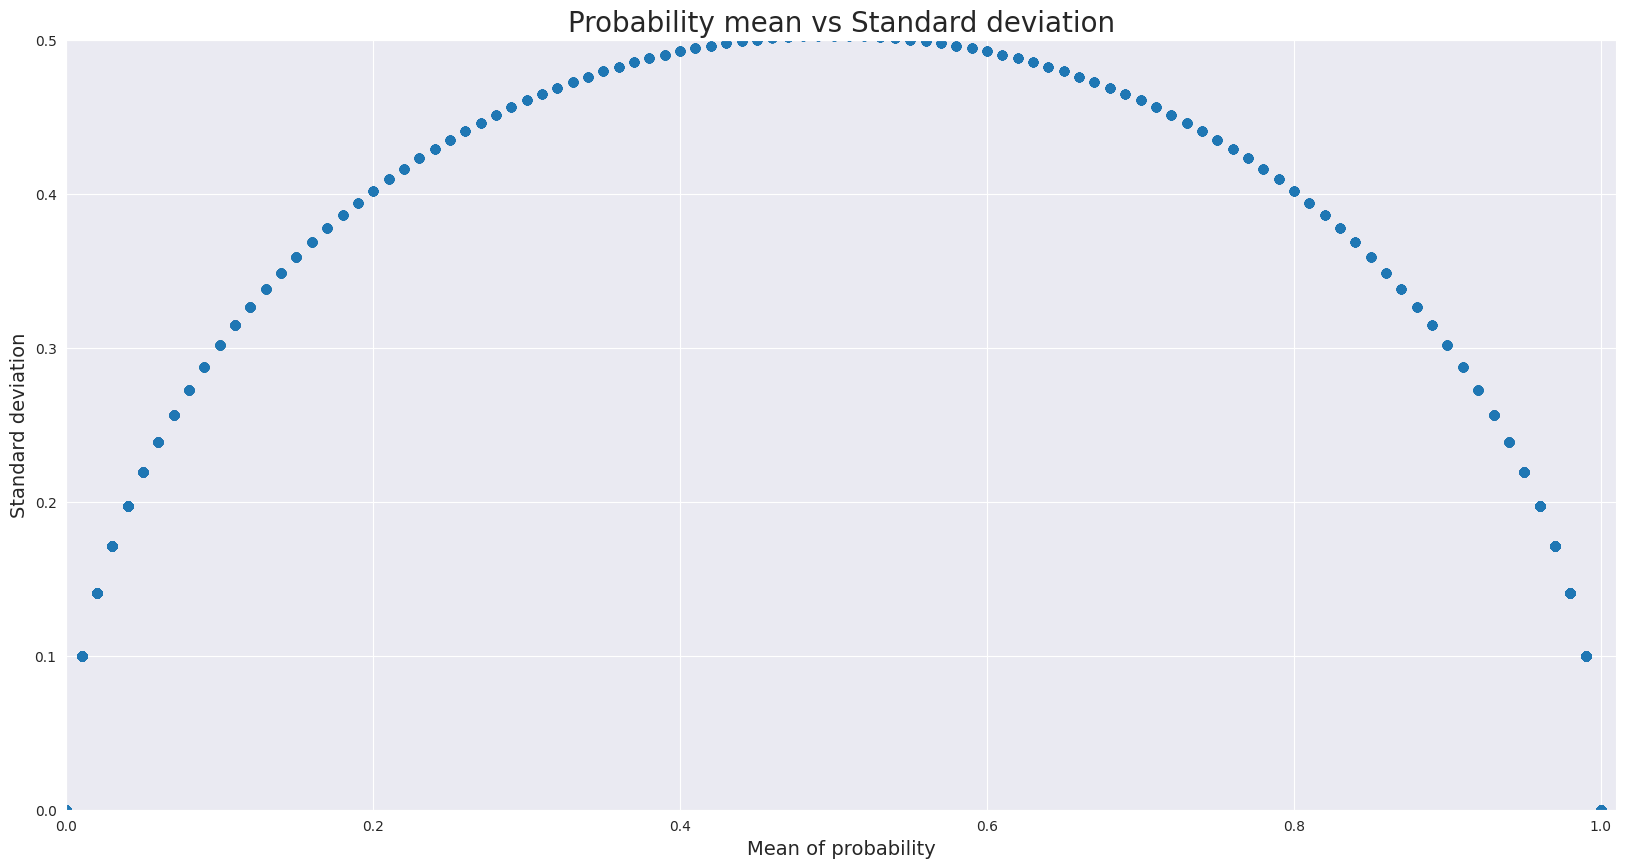

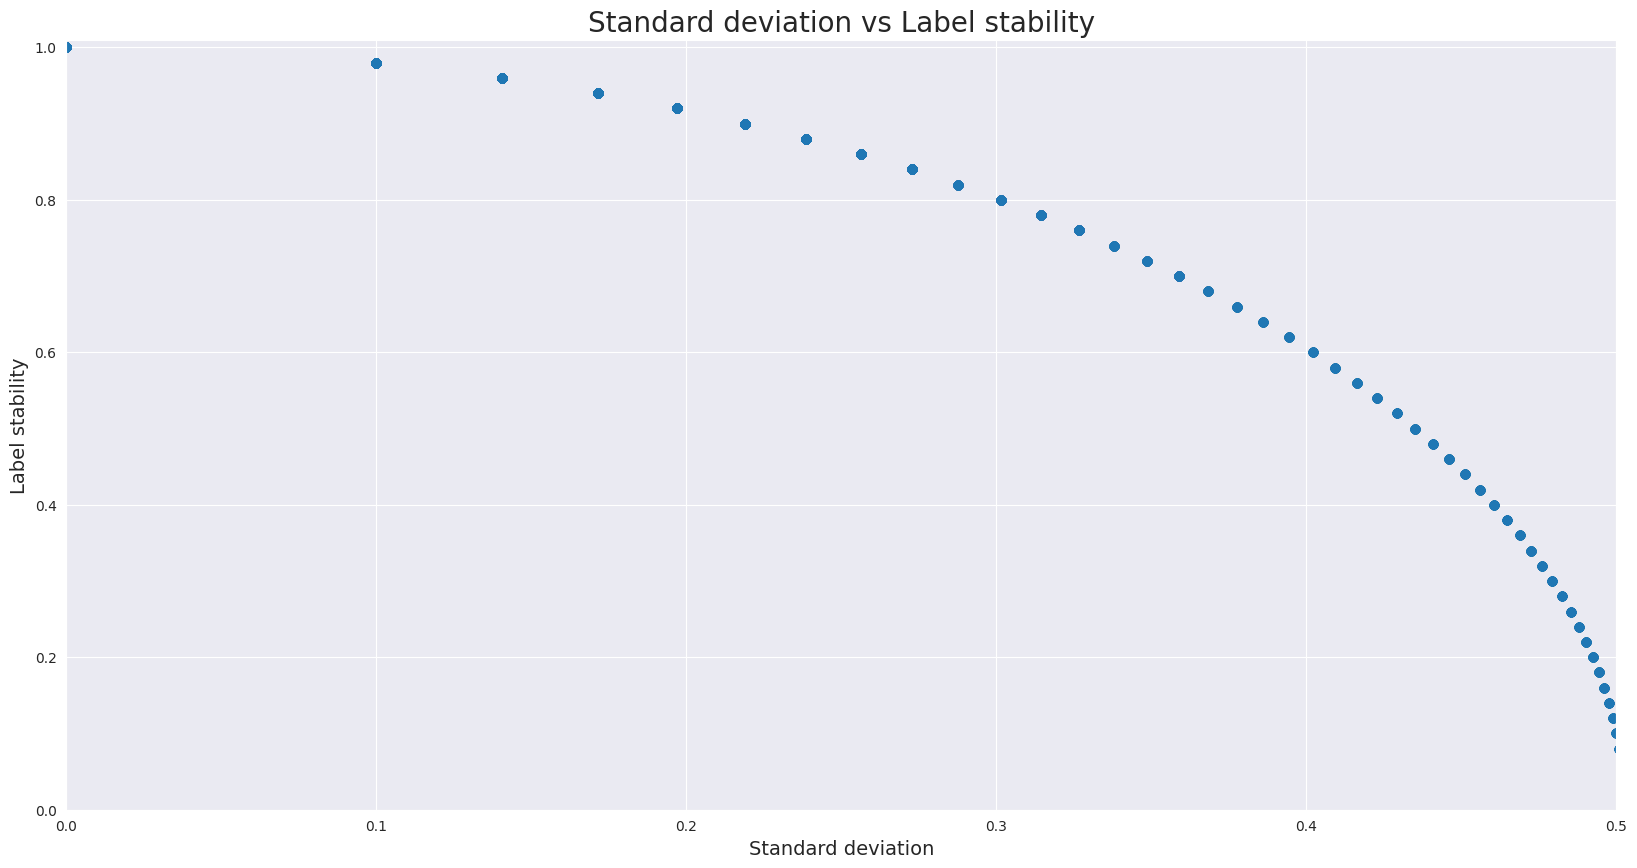

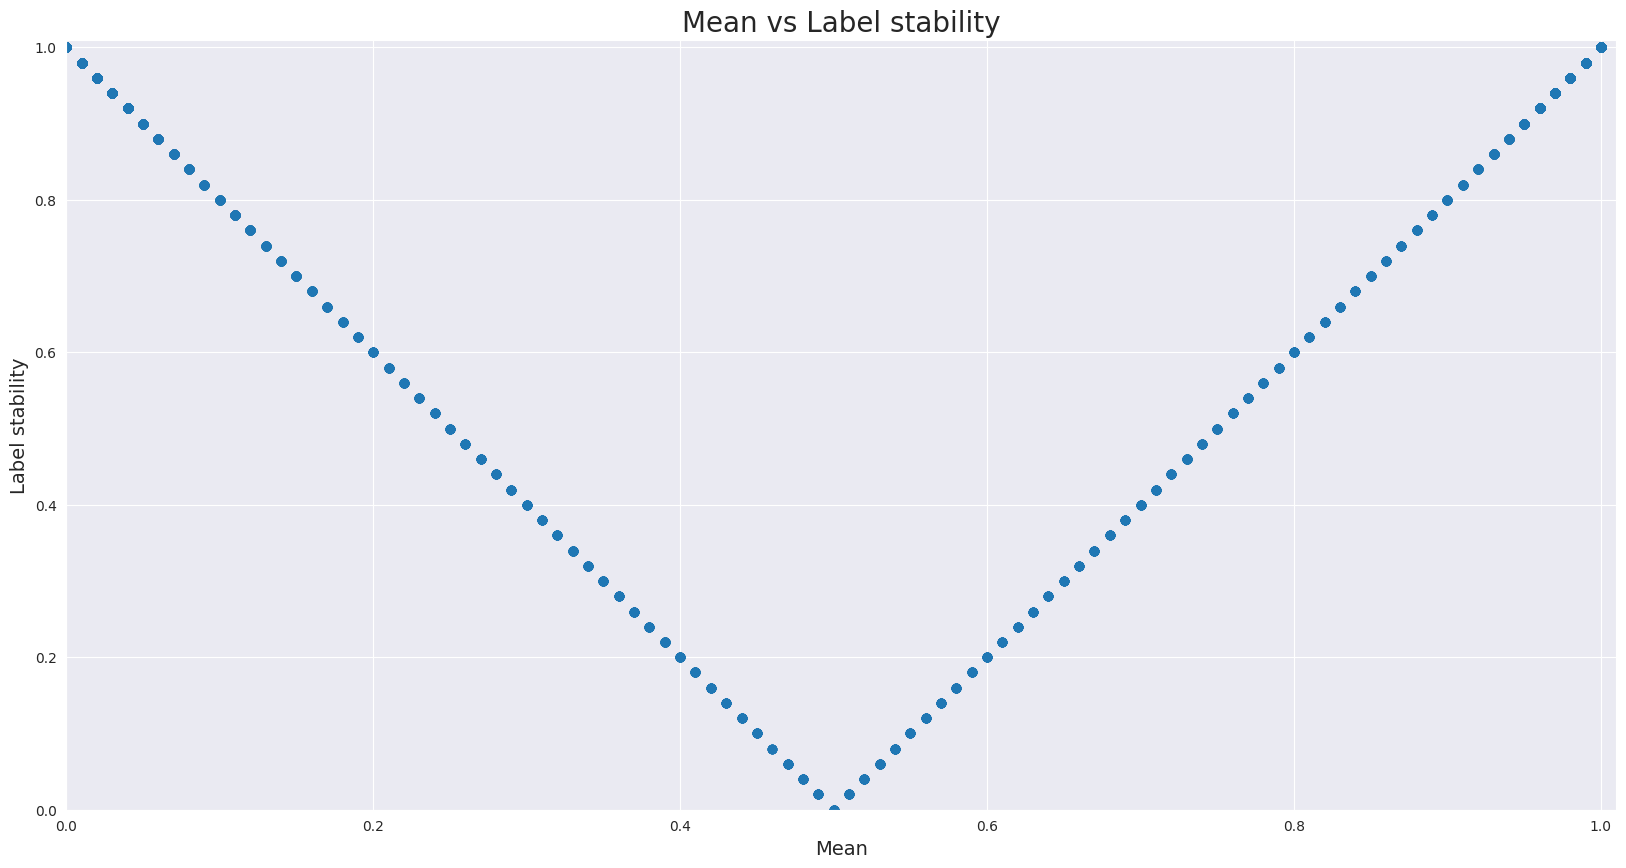

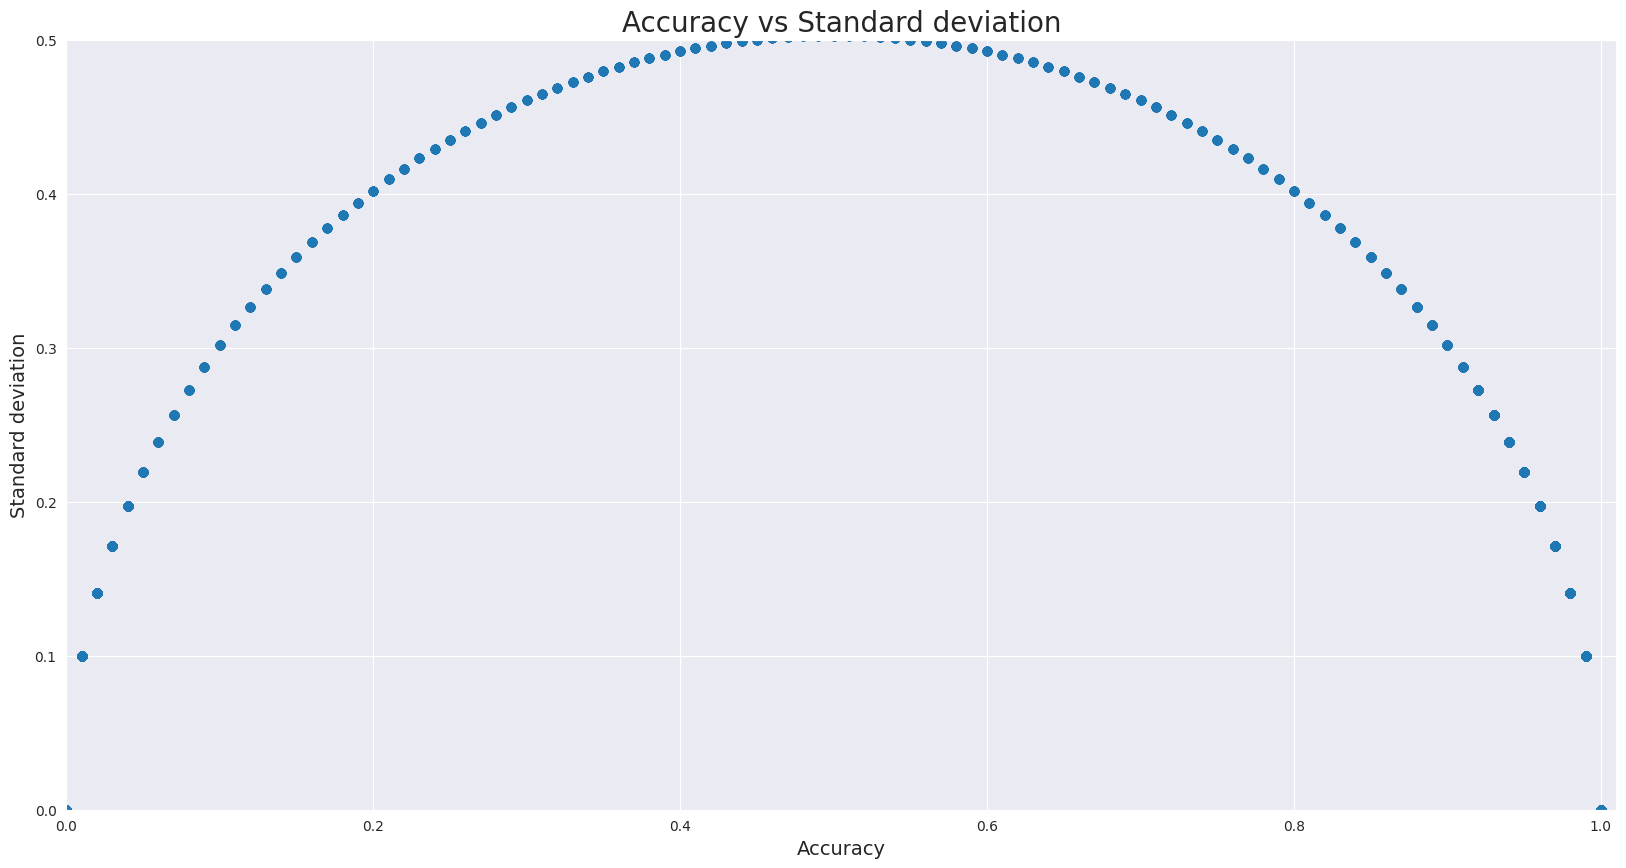

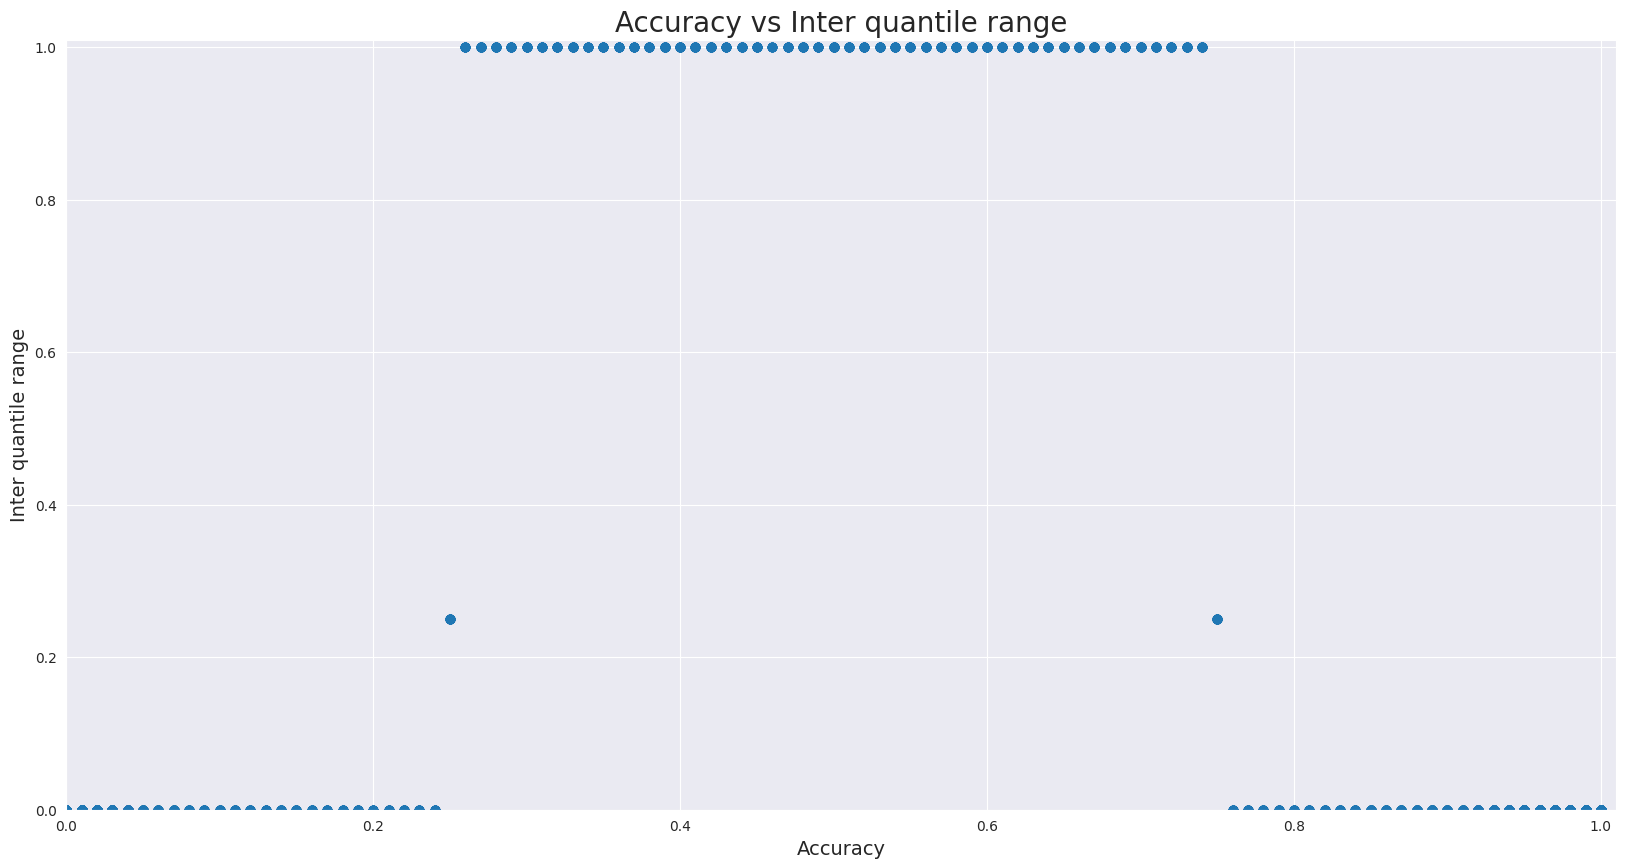


[Experiment 1] Metrics confusion matrix:


,overall,SEX_RAC1P_priv,SEX_RAC1P_dis,SEX_priv,SEX_dis,RAC1P_priv,RAC1P_dis
General_Ensemble_Accuracy,0.823700,0.854700,0.803100,0.856100,0.792500,0.820700,0.829500
Mean,0.553000,0.500000,0.575400,0.521900,0.583000,0.543600,0.570900
Std,0.054600,0.051900,0.061800,0.053300,0.055900,0.052300,0.059000
IQR,0.058700,0.055700,0.066200,0.056600,0.060800,0.056700,0.062500
Entropy,0.079900,0.000000,0.110800,0.064800,0.094400,0.074300,0.090500
Jitter,0.049200,0.038100,0.069900,0.038600,0.059300,0.045800,0.055600
Per_Sample_Accuracy,0.817000,0.849300,0.791400,0.850800,0.784500,0.815000,0.820900
Label_Stability,0.932200,0.949200,0.900600,0.948700,0.916300,0.937100,0.922900
TPR,0.855732,0.870261,0.845855,0.877013,0.831678,0.849555,0.868430
TNR,0.797849,0.838540,0.771955,0.836523,0.765066,0.796226,0.800749


100%|██████████| 1/1 [04:07<00:00, 247.96s/it]

In [84]:
# TOD: add dataset as a parameter
run_experiment(exp_num=1, model_seed=100)

### Experiment 2

In [85]:
# run_experiment(exp_num=2, model_seed=200)